In [1]:
# !pip install --upgrade "protobuf>3.20"
# !pip install networkx

In [2]:
from datasets import load_dataset
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
# from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from transformers import BartForConditionalGeneration, BartTokenizer, TrainingArguments
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import threading
import time
from threading import Thread
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, explode, col, arrays_zip
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType
import math
import random
import chromadb
from chromadb.config import Settings
chroma_client = chromadb.PersistentClient(path="./")
from pyspark.sql import functions as F
import sqlite3
import re
import torch
import findspark
from googlesearch import search
findspark.init()

C:\Users\Akshay\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# spark = SparkSession.builder \
#     .master("local") \
#     .config("spark.driver.memory", "2g") \
#     .config("spark.executor.memory", "2g") \
#     .appName("test") \
#     .getOrCreate()
# df = spark.createDataFrame([(1, 'Alice'), (2, 'Bob')], ['id', 'name'])
# df.show()

### Context Based Dataset

In [29]:
dataset_1 = load_dataset("9wimu9/eli5_mult_answers_en_no_answer_in_context") # in deep
dataset_2 = load_dataset("mlxen/squad_1_1_smallcase_context") #one word
dataset_3 = load_dataset("nbtpj/multi-context-long-answer-dataset") # in short
dataset_8 = load_dataset("LasRuinasCirculares/sft_correct")
dataset_9 = load_dataset("robbiegwaldd/rephrase_train") # all
ds = load_dataset("addy88/nq-question-answeronly")
ds = load_dataset("iarfmoose/question_generator")

In [30]:
dataset_1

DatasetDict({
    train: Dataset({
        features: ['question', 'contexts', 'gold_answer'],
        num_rows: 71236
    })
    test: Dataset({
        features: ['question', 'contexts', 'gold_answer'],
        num_rows: 7916
    })
})

In [31]:
agent_1 = dataset_1["train"]["question"]
raw_context = dataset_1["train"]["contexts"]
modified_context = []
for c in raw_context:
    final_string = ""
    for i in c:
        final_string = final_string+" "+ i
    modified_context.append(final_string)
context = modified_context
agent_2 = dataset_1["train"]["gold_answer"]

In [32]:
agent_1.extend(dataset_2["train"]["question"])
context.extend(dataset_2["train"]["context"])
agent_2.extend([i["text"][0] for i in dataset_2["train"]["answers"]])

agent_1.extend([i.split("Question:")[1].replace("Answer:","") for i in dataset_8["train"]["instruction"]])
context.extend([i.replace("Evidence:","").replace("**","").split("Question:")[0].replace("\n","") for i in dataset_8["train"]["instruction"]])
agent_2.extend(dataset_8["train"]["output"])

In [33]:
channelNames =["pubmed_qa_X_squad_num_channel_1_test","pubmed_qa_X_squad_num_channel_1_train","pubmed_qa_X_squad_num_channel_2_test","pubmed_qa_X_squad_num_channel_2_train","pubmed_qa_X_squad_num_channel_3_test","pubmed_qa_X_squad_num_channel_3_train","pubmed_qa_X_squad_num_channel_4_test","pubmed_qa_X_squad_num_channel_4_train","pubmed_qa_num_channel_1_test","pubmed_qa_num_channel_1_train","pubmed_qa_num_channel_2_test","pubmed_qa_num_channel_2_train","pubmed_qa_num_channel_3_test","pubmed_qa_num_channel_3_train","pubmed_qa_num_channel_4_test","pubmed_qa_num_channel_4_train","squad_num_channel_1_test","squad_num_channel_1_train","squad_num_channel_2_test","squad_num_channel_2_train","squad_num_channel_3_test","squad_num_channel_3_train","squad_num_channel_4_test","squad_num_channel_4_train"]

In [34]:
question = []
cont = []
answer = []
for channel in channelNames:
    question.extend([i[0].split("<||||>")[0] for i in dataset_3[channel]["context"]])
    cont.extend([i[0].split("<||||>")[1] for i in dataset_3[channel]["context"]])
    answer.extend([i for i in dataset_3[channel]["answer"]])
temp_df = pd.DataFrame()
temp_df["question"] = question
temp_df["cont"] = cont
temp_df["answer"] = answer
df = temp_df.drop_duplicates(subset=['question','cont','answer'], keep='first')
agent_1.extend(df["question"].tolist())
context.extend(df["cont"].tolist())
agent_2.extend(df["answer"].tolist())

In [35]:
datasets = ["bart-base-squad.end2end.amazon","bart-base-squad.end2end.new_wiki","bart-base-squad.end2end.nyt","bart-base-squad.end2end.reddit","bart-base-squad.multitask.amazon","bart-base-squad.multitask.new_wiki","bart-base-squad.multitask.nyt","bart-base-squad.multitask.reddit","bart-base-squad.pipeline.amazon","bart-base-squad.pipeline.new_wiki","bart-base-squad.pipeline.nyt","bart-base-squad.pipeline.reddit","bart-base-squad.qg_reference.amazon","bart-base-squad.qg_reference.new_wiki","bart-base-squad.qg_reference.nyt","bart-base-squad.qg_reference.reddit","bart-large-squad.end2end.amazon","bart-large-squad.end2end.new_wiki","bart-large-squad.end2end.nyt","bart-large-squad.end2end.reddit","bart-large-squad.multitask.amazon","bart-large-squad.multitask.new_wiki","bart-large-squad.multitask.nyt","bart-large-squad.multitask.reddit","bart-large-squad.pipeline.amazon","bart-large-squad.pipeline.new_wiki","bart-large-squad.pipeline.nyt","bart-large-squad.pipeline.reddit","bart-large-squad.qg_reference.amazon","bart-large-squad.qg_reference.new_wiki","bart-large-squad.qg_reference.nyt","bart-large-squad.qg_reference.reddit","t5-base-squad.end2end.amazon","t5-base-squad.end2end.new_wiki","t5-base-squad.end2end.nyt","t5-base-squad.end2end.reddit","t5-base-squad.multitask.amazon","t5-base-squad.multitask.new_wiki","t5-base-squad.multitask.nyt","t5-base-squad.multitask.reddit","t5-base-squad.pipeline.amazon","t5-base-squad.pipeline.new_wiki","t5-base-squad.pipeline.nyt","t5-base-squad.pipeline.reddit","t5-base-squad.qg_reference.amazon","t5-base-squad.qg_reference.new_wiki","t5-base-squad.qg_reference.nyt","t5-base-squad.qg_reference.reddit","t5-large-squad.end2end.amazon","t5-large-squad.end2end.new_wiki"]

In [36]:
for i in tqdm(range(0,len(datasets))):
    # print(f'\rDataset Name: {dataset}', end='', flush=True)
    ds = load_dataset("lmqg/qa_squadshifts_synthetic", datasets[i])
    agent_1.extend(i for i in ds["train"]["question"])
    context.extend(i for i in ds["train"]["context"])
    agent_2.extend(i["text"][0] for i in ds["train"]["answers"])

100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


In [37]:
dataset_9

DatasetDict({
    train: Dataset({
        features: ['id', 'original_snippet', 'rephrased_snippet'],
        num_rows: 291032
    })
})

In [38]:
len(agent_1)

1469571

In [39]:
questions = []
answers = []
conte = []
split_qa = [i.split("\n\n") for i in dataset_9["train"]["rephrased_snippet"]]
cont = [i.replace("\n","") for i in dataset_9["train"]["original_snippet"]]
for i in tqdm(range(0,len(split_qa))):
    q = [];a = [];c = []
    if "\nAnswer" not in split_qa[i][0]:
        if len(split_qa[i]) % 2 != 0:
            split_qa[i] = split_qa[i][:-1]
        for j in range(0,len(split_qa[i]),2):
            q.append(split_qa[i][j])
            a.append(split_qa[i][j+1])
            c.append(cont[i])
    else:
        new_split = [j.split("\n") for j in split_qa[i]]
        for j in range(0,len(new_split)):
            if len(new_split[j]) %2 !=0:
                continue
            q.append(new_split[j][0].replace("Question:",""))
            a.append(new_split[j][1].replace("Answer:",""))
            c.append(cont[i])
    answers.extend(a)
    questions.extend(q)
    conte.extend(c)
    # print(len(answers),len(questions))
    # print(split_qa[i])
agent_1.extend(questions)
context.extend(conte)
agent_2.extend(answers)

100%|██████████| 291032/291032 [00:00<00:00, 369566.84it/s]


In [40]:
len(agent_1)

1802143

In [41]:
len(context)

1802143

In [42]:
len(agent_2)

1802143

In [43]:
temp_df = pd.DataFrame()
temp_df["agent_1"] = agent_1
temp_df["context"] = context
temp_df["agent_2"] = agent_2

In [5]:
temp_df.to_csv("../Data/CleanedDatasets/ContextBasedQuestions.csv")

In [16]:
temp_df = pd.read_csv("../Data/CleanedDatasets/ContextBasedQuestions.csv")

In [40]:
temp_df.head()

,agent_2,agent_1
0,agent_2:These foods contain certain sugars tha...,<context> Actually it is because most of peop...
1,agent_2:I'd answer the question but the defaul...,<context> The decay of false vacuum is a fasc...
2,agent_2:Essentially the events in Crimea threa...,<context> National Sovereignty is a very big ...
3,agent_2:To have as little protection as is saf...,<context> Most helmets are pretty similar in ...
4,"agent_2:Your eyes are magnificent sensors, and...",<context> The reason is that a camera is basi...


In [18]:
temp_df["agent_2"] = "agent_2:"+temp_df["agent_2"]
temp_df["agent_1"] = "<context> " + temp_df["context"] + "agent_1:"+temp_df["old_agent_1"]

In [19]:
temp_df.dropna(inplace = True)
temp_df.reset_index(inplace=True)

In [36]:
import math
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
agent_1_extended = []
agent_2_extended = []
tokenizedLengthList = []
idx = 0
for input_text in tqdm(temp_df["agent_1"].to_list()):
    try:
        input_tokenized = tokenizer(input_text,return_tensors='pt')
        tokenizedLength = len(input_tokenized["input_ids"][0])
        tokenizedLengthList.append(tokenizedLength)
        if tokenizedLength < 510:
            agent_1_extended.append(input_text)
            agent_2_extended.append(temp_df["agent_2"][idx])
    except Exception as e:
        print(e)
    idx = idx+1
    # if tokenizedLength > 510 and tokenizedLength < 1500:
        
    #         num_of_loops = math.ceil(tokenizedLength/510)
    #         slice_length = math.ceil(len(input_text)/num_of_loops)
    #         for i in range(0,num_of_loops):
    #             if i == 0:
    #                 agent_1_extended.append("agent_1:"+(input_text[i*slice_length:(i*slice_length)+slice_length])+"<question>"+temp_df["old_agent_1"][idx])
    #             else:
    #                 agent_1_extended.append("agent_1:"+"<context>"+(input_text[(i*slice_length)-50:(i*slice_length)+slice_length])+"<question>"+temp_df["old_agent_1"][idx])
    
    # else:
    #     agent_1_extended.append("agent_1:"+input_text)

100%|██████████| 1799426/1799426 [45:44<00:00, 655.72it/s] 


In [37]:
len(agent_1_extended)

1400831

In [38]:
len(agent_2_extended)

1400831

In [39]:
temp_df = pd.DataFrame()
temp_df["agent_2"] =agent_2_extended
temp_df["agent_1"] =agent_1_extended

In [11]:
agent_1_extended[2]

'<context>  National Sovereignty is a very big deal so anytime a country (especially a country with nukes) starts to reject previously agreed upon borders it is a big deal.\n\nThe reason you should care is that Russia has been for quite sometime trying to maintain some degree of influence over several former Soviet republics.  As some of these states move away from Russia, it is going to cause conflict and potentially a full blown war. likely to evolve into nothing\n\ncrimea was granted to ukraine as a restitution gift and well over half the population is in favour of annexation\n\nthey already speak russian and maintain russian culture\n\nputin is a total dick but once this blows over they will pay lower taxes to an equally corrupt government and receive additional social benefits\n\nyeah, its a huge problem that a part of a country is essentially being taken over but it hardly sets precedent for speculations of a third world war\n\nagent_1:what is the big deal about russia invading u

In [55]:
temp_df.to_csv("../Data/CleanedDatasets/ContextBasedQuestions.csv")

In [53]:
temp_df["agent_1"][1400700]

"<context> 5 best Java seeds for Minecraft 1.19 updateThe 1.19 update for Minecraft introduced many new features. \xa0Two major biomes, Deep Dark and Mangrove Swamp, have been added to the game and are quickly becoming quite popular.The two biomes are arguably the biggest addition to the game. \xa0Deep Dark and Mangrove Swamp both provide reasons to visit them, but there's only one problem: they can be difficult to find.Minecraft seeds to try in Java Edition version 1.19Multiple Blue Rings\xa0Note: The 1.18 update introduced seed universality, so seeds will work on both versions with minimal differences. \xa0The main differences are when moving from Java to Bedrock, but not vice versa.The ancient city in 1.19 is a new but extremely rare structure. \xa0It's a challenge to trace a regular Deep Dark with just the Skulk and the Warden. \xa0Most of those found do not even contain any ancient cities.Seed: -457009213479927390This seed puts players into an amazing spawn. \xa0Gamers come right 

In [54]:
temp_df["agent_2"][1400700]

'agent_2: In Minecraft 1.19, there are two new biomes added: "Deep Dark" and "Mangrove Swamp". The Deep Dark biome provides reasons to visit it but can be difficult to find due to its location near a swamp. Meanwhile, the Mangrove Swamp biome has only one problem - it can be difficult to find as well. Minecraft seeds like -457009213479927390, -6709148406763899126, and -2110863992403414331 can be used to trace a Deep Dark with just the Skulk and Warden. These seeds contain good loot but do not necessarily have Mangrove Swamp as they are located in swamps instead of in the swamp biome. The seeds -2110863992403414331 and 1450778142214593647 can be used to find Mangrove Swamp by using a village as an alternative spawn point. The seeds -6709148406763899126 and 6705'

### RAG Pipeline using Chroma Database

In [2]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = '../Saved_Models/Sky/fine-tuned-bert-sentiment_2024_10_04_0'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)
model = model.to(device)
# data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#### Data Cleaning

In [3]:
def clean_latex(text):
    # Remove LaTeX commands like {\\displaystyle}, {\\text{}}, etc.
    cleaned_text = re.sub(r'\\displaystyle|\\text\{.*?\}', '', text)
    
    # Remove any LaTeX curly braces and unnecessary whitespaces
    cleaned_text = re.sub(r'\\[a-z]+|{|}', '', cleaned_text)
    
    # Replace LaTeX-specific representations like \\dots with their equivalent
    cleaned_text = re.sub(r'\\dots', '...', cleaned_text)
    
    # Remove multiple spaces introduced by LaTeX removal
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

In [4]:
class ThreadWithReturnValue(Thread):
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}, Verbose=None):
        Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None

    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args,
                                                **self._kwargs)
    def join(self, *args):
        Thread.join(self, *args)
        return self._return

In [5]:
def data_mining(website):
    filtered_content = ""
    if (".gov" not in website) and ("linkedin.com" not in website) and ("reddit.com" not in website):
        URL = website
        r = requests.get(URL) 
        soup = BeautifulSoup(r.content, 'html5lib')
        for tag in soup(['nav', 'header', 'footer', 'script', 'style', 'aside']):
            tag.decompose()
        for tag in soup.find_all(['h1', 'h2', 'h3', 'h4', 'p', 'li','strong']):
            filtered_content = filtered_content+tag.get_text()
        remove_latex = clean_latex(filtered_content)
        chunks = create_chunks(remove_latex)
    return chunks


In [6]:
def get_google_search_links(query):
    return [link for link in search(query)]

In [7]:
def create_chunks(cleaned_data):
    ids_list = []
    final_chunks = []
    random_number = random.randint(0,10000000000)
    loop = math.ceil(len(cleaned_data)/2000)
    for i in range(0,loop):
        if i ==0:
            final_chunks.append(cleaned_data[(i*2000):(i+1)*2000])
        else:
            final_chunks.append(cleaned_data[(i*2000)-500:(i+1)*2000])
        ids_list.append(str(random_number+(i/50)))
    return (final_chunks,ids_list)
    # return final_chunks

In [22]:
# spark.stop()
# spark = SparkSession.builder \
#     .master("local") \
#     .config("spark.driver.memory", "1g") \
#     .config("spark.executor.memory", "1g") \
#     .appName("WebScrapingWithPySpark") \
#     .getOrCreate()

# cleaned_data_udf = udf(clean_latex, StringType())
# # create_chunks_udf = udf(create_chunks, ArrayType(StringType()), ArrayType(StringType()))
# schema = StructType([
#     StructField("chunks", ArrayType(StringType())),
#     StructField("ids", ArrayType(StringType()))
# ])
# create_chunks_udf = udf(create_chunks, schema)


In [8]:
collection = chroma_client.get_or_create_collection(name="my_collection")

In [9]:
query = ["How to make crossiant?","What is Big Data?","Which of the following is a Characteristic of BigDdata?","What is Hadoop?","What is the Function of RAM?"]

In [10]:
q = query[1]

In [36]:
###############################Data Fecthing################################
def fetch_data(q):
    website_links = get_google_search_links(q)
    threads_list = [ThreadWithReturnValue(target=data_mining, args=(website,)) for website in website_links[:5]]
    [thread.start() for thread in threads_list]
    fetched_data = [thread.join() for thread in threads_list]
    return fetched_data

#### RAG Pipeline

In [39]:
start_time = time.time()
fetched_data = fetch_data(q)
# print("Query : {}".format(q))

final_chunks = []
final_ids = []
for f in fetched_data:
    for i in f[0]:
        final_chunks.append(i)
    for i in f[1]:
        final_ids.append(i)

# # print(flat_list)

collection.add(
    documents=final_chunks,
    ids=final_ids
)
results = collection.query(
    query_texts=q, # Chroma will embed this for you
    n_results=2 # how many results to return
)
print(results['distances'])


input_ids = tokenizer.encode("<context>{}agent_1:{}".format(results["documents"][0][0],q), return_tensors='pt',max_length=512, truncation=True).to(device)
output = model.generate(
    input_ids, 
    max_length=128, 
    num_beams=10, 
    early_stopping=True, 
    no_repeat_ngram_size=2,  # Prevent repeating n-grams
    num_return_sequences=1,  # Number of sequences to return
    temperature=0.7,  # Sampling temperature
    top_k=50,  # Top-K sampling
    top_p=0.9  # Top-p (nucleus) sampling
)
resp = tokenizer.decode(output[0], skip_special_tokens=True)
print(resp)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

[[0.4907780587673187, 0.49605846405029297]]
In the 1960s, the United States established a massive data center to store millions of tax records. This marked the beginning of digital data management. However, with advancements in technology and sophisticated analytics capabilities, businesses are now able to save large amounts of data for pennies on the dollar using data lakes or data warehouses like Snowflake. As a result, big data has become more complex and vast than ever before, making it challenging for organizations to gather, manage, understand, and utilize data effectively. It also presents challenges in IT, business, as well as emerging analytics technologies. To address these issues, we provide guidance on how
Execution time: 3.7856297492980957 seconds


In [41]:
collection.count()

2453

In [ ]:
# temp_df = list(zip(website_links, fetched_data))
# uncleaned_df = spark.createDataFrame(temp_df, ["url", "uncleaned_data"])
# cleaned_df = uncleaned_df.withColumn("cleaned_data", cleaned_data_udf("uncleaned_data"))
# clean_df = cleaned_df.withColumn("processed", create_chunks_udf("cleaned_data"))
# clean_df = clean_df.select(
#     F.col('processed.chunks').alias("chunks"),
#     F.col('processed.ids').alias("ids")
# )
# chunks_df = clean_df.withColumn("zipped", arrays_zip("chunks", "ids")) \
#        .withColumn("exploded", explode("zipped")) \
#        .select(clean_df.chunks.alias("chunks_array"), "exploded.chunks", "exploded.ids")
# chunks_df = chunks_df.drop('chunks_array')

In [ ]:
# chunks_df.show()
# pandas_df = chunks_df.toPandas()
# collection.add(
#     documents=list(pandas_df["chunks"]),
#     ids=list(pandas_df["ids"])
# )
# results = collection.query(
#     query_texts=[q], # Chroma will embed this for you
#     n_results=2 # how many results to return
# )
# print(results['distances'])

In [ ]:
# print("Query : {}".format(q))
# input_ids = tokenizer.encode("<context>{}agent_1:{}".format(results["documents"][0][0],query), return_tensors='pt',max_length=1024, truncation=True).to(device)
# output = model.generate(
#     input_ids, 
#     max_length=512, 
#     num_beams=10, 
#     early_stopping=True, 
#     no_repeat_ngram_size=2,  # Prevent repeating n-grams
#     num_return_sequences=1,  # Number of sequences to return
#     temperature=0.7,  # Sampling temperature
#     top_k=50,  # Top-K sampling
#     top_p=0.9  # Top-p (nucleus) sampling
# )
# resp = tokenizer.decode(output[0], skip_special_tokens=True)
# print(resp)

In [24]:
# start_time = time.time()
# website_links = get_google_search_links(q)

# ###############################SPARK################################

# threads_list = [ThreadWithReturnValue(target=data_mining, args=(website,)) for website in website_links[:5]]
# [thread.start() for thread in threads_list]
# fetched_data = [thread.join() for thread in threads_list]

# temp_df = list(zip(website_links, fetched_data))
# uncleaned_df = spark.createDataFrame(temp_df, ["url", "uncleaned_data"])
# cleaned_df = uncleaned_df.withColumn("cleaned_data", cleaned_data_udf("uncleaned_data"))
# clean_df = cleaned_df.withColumn("processed", create_chunks_udf("cleaned_data"))

# clean_df = clean_df.select(
#     F.col('processed.chunks').alias("chunks"),
#     F.col('processed.ids').alias("ids")
# )

# chunks_df = clean_df.withColumn("zipped", arrays_zip("chunks", "ids")) \
#        .withColumn("exploded", explode("zipped")) \
#        .select(clean_df.chunks.alias("chunks_array"), "exploded.chunks", "exploded.ids")
# chunks_df = chunks_df.drop('chunks_array')

# # pandas_df = chunks_df.toPandas()
# # conn = sqlite3.connect('chroma.sqlite3')  # 'example.db' is the SQLite database file
# # pandas_df.to_sql('table_name', conn, if_exists='replace', index=False)
# # conn.close()
# # spark.stop()

# ###########################CHROMA###################################

# # chunks_df.show()
# pandas_df = chunks_df.toPandas()
# collection.add(
#     documents=list(pandas_df["chunks"]),
#     ids=list(pandas_df["ids"])
# )
# results = collection.query(
#     query_texts=[q], # Chroma will embed this for you
#     n_results=2 # how many results to return
# )
# # print(results['distances'])

# ###########################LLM##################################

# print("Query : {}".format(q))
# input_ids = tokenizer.encode("<context>{}agent_1:{}".format(results["documents"][0][0],query), return_tensors='pt',max_length=1024, truncation=True).to(device)
# output = model.generate(
#     input_ids, 
#     max_length=512, 
#     num_beams=10, 
#     early_stopping=True, 
#     no_repeat_ngram_size=2,  # Prevent repeating n-grams
#     num_return_sequences=1,  # Number of sequences to return
#     temperature=0.7,  # Sampling temperature
#     top_k=50,  # Top-K sampling
#     top_p=0.9  # Top-p (nucleus) sampling
# )
# resp = tokenizer.decode(output[0], skip_special_tokens=True)
# print(resp)
# print()
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

Query : How to make crossiant?
agent_2:A professional chef’s tips for making French croissants.

Query : What is Big Data?
The concept of big data encompasses a wide range of data sources and formats, including web logs, social media interactions, ecommerce and online transactions, financial transactions. However, due to increasing volume, velocity, and variety, traditional databases are unable to handle this challenge effectively. To overcome these challenges, organizations must employ cutting-edge technologies such as Hadoop, which allow them to collect and store large datasets while also analyzing them in order to uncover new and valuable insights. By doing so, companies can streamline their operations and increase productivity and competitiveness.

Query : Which of the following is a Characteristic of BigDdata?
agent_2:What are the characteristics of big data?
1) There is a lot of data
2) Big data formats change rapidly
3) Which of the following is not an issue
4) It can come from 

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 59166)
Traceback (most recent call last):
  File "C:\Users\Akshay\anaconda3\envs\tf\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\Akshay\anaconda3\envs\tf\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\Akshay\anaconda3\envs\tf\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\Akshay\anaconda3\envs\tf\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "C:\Users\Akshay\anaconda3\envs\tf\lib\site-packages\pyspark\accumulators.py", line 295, in handle
    poll(accum_updates)
  File "C:\Users\Akshay\anaconda3\envs\tf\lib\site-packages\pyspark\accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "C:\Users\Akshay\anaconda

In [20]:
from torch.nn.functional import softmax

# Tokenize the input
input_ids = tokenizer.encode("<context>{}agent_1:{}".format(results["documents"][0][0],query), return_tensors='pt', max_length=512, truncation=True).to(device)

# Forward pass through the model to get the logits
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)
    logits = outputs.logits

# Get the predicted token ids from the logits (the most likely tokens)
predicted_ids = torch.argmax(logits, dim=-1)

# Calculate the probabilities (softmax) for the predicted tokens
probabilities = softmax(logits, dim=-1)

# Get the probabilities of the predicted tokens
predicted_probabilities = probabilities.gather(2, predicted_ids.unsqueeze(-1)).squeeze(-1)

# Calculate the confidence score as the average probability of the predicted tokens
confidence_score = predicted_probabilities.mean().item()

print("Generated Output:", tokenizer.decode(predicted_ids[0], skip_special_tokens=True).replace("\n",""))
print("Confidence Score:", confidence_score)

Generated Output: agentagent>:Data and Data management Ben Lutkevich, Site Editor Ivy Wigmore, are the 3 V's of big data? The 3 V's (volume, velocity and variety) are three defining characteristics or dimensions of big data. Volume refers to the amount of data, velocity refers to the speed of data processing, and variety refers to the number of types of data. As to the 3 V's model, the challenges of big data management result from the expansion of all three properties, rather than just the volume alone or the sheer amount of data to be managed. An organization can be better equipped to deal with big data challenges through understanding the 3 V's of big data management. Gartner analyst Doug Laney introduced the 3 V's concept in a 2001 Meta Group research publication, "3D Data Management: Controlling Data Volume, Velocity and Variety." More recently, additional V's have been proposed for addition to the model, including variability -- the increase in the range of values typical of a lar

### KGLA

In [4]:
URL = "https://en.wikipedia.org/wiki/Machine_learning"

In [5]:
r = requests.get(URL) 
soup = BeautifulSoup(r.content, 'html5lib')

In [6]:
header = soup.find('h1')
header.text

'Machine learning'

In [7]:
for tag in soup(['nav', 'header', 'footer', 'script', 'style', 'aside']):
    tag.decompose()

In [8]:
imp_tags = soup.find_all(['h1', 'h2', 'h3', 'h4','h5', 'p', 'li','strong','ul','ol'])

In [9]:
soup.find_all("h1")

[]

In [10]:
imp_tags

[<ul><li><a href="/wiki/Supervised_learning" title="Supervised learning">Supervised learning</a></li>
 <li><a href="/wiki/Unsupervised_learning" title="Unsupervised learning">Unsupervised learning</a></li>
 <li><a class="mw-redirect" href="/wiki/Semi-supervised_learning" title="Semi-supervised learning">Semi-supervised learning</a></li>
 <li><a href="/wiki/Self-supervised_learning" title="Self-supervised learning">Self-supervised learning</a></li>
 <li><a href="/wiki/Reinforcement_learning" title="Reinforcement learning">Reinforcement learning</a></li>
 <li><a href="/wiki/Meta-learning_(computer_science)" title="Meta-learning (computer science)">Meta-learning</a></li>
 <li><a href="/wiki/Online_machine_learning" title="Online machine learning">Online learning</a></li>
 <li><a class="mw-redirect" href="/wiki/Batch_learning" title="Batch learning">Batch learning</a></li>
 <li><a href="/wiki/Curriculum_learning" title="Curriculum learning">Curriculum learning</a></li>
 <li><a href="/wiki/

In [11]:
imp_tags[200].text

'Turing test'

In [12]:
imp_tags[200].find_all()

[<a href="/wiki/Turing_test" title="Turing test">Turing test</a>]

In [13]:
'''
This function returns the key of priority tags whose value is true.
'''
def index_of_true(priority_tags):
    key_true = []
    for tag in priority_tags.keys():
        if priority_tags[tag] == True:
            key_true.append(tag)
        else:
            pass
    return key_true

In [14]:
def create_network_graph(key,value):
    nxG = nx.Graph()
    nxG.add_node(key)
    for v in value:
        nxG.add_edge(key, v)
    return nxG

In [15]:
def find_nested_links(tag):
    links = []
    nested_tags = tag.find_all('a')
    if len(nested_tags) != 0:
        for i in nested_tags:
            try:
                links.append(str(i).split(" ")[1].split("href=")[1]) #Storing the links
            except IndexError as index_error:
                pass
    return links

In [23]:
def adjust_tags_based_on_priority(priority_tags,key_true,tag):
    print(priority_tags)
    print(key_true)
    print(tag)
    return 0

In [26]:
priority_tags = {"h1":False,"h2":False,"h3":False,"h4":False,"h5":False,"ul":False,"ol":False,"li":False,"strong":False,"p":False,"a":False}
KGLA_struct = {}
network_graphs = []
links = []
last_tag = ""
temp_counter = 0
for idx,tag in enumerate(imp_tags):
    key_true = index_of_true(priority_tags)
    if len(key_true) == 0 and tag.name in ["ul","li","ol"]: #If there is no heading, We will find the link and store them directly in a list for futher scraping
        links.extend(find_nested_links(tag))
    else:
        temp_counter = temp_counter+1
        # print(key_true)
        # print(tag)
        if tag.name in key_true:
            #Do nothing
            pass
        else:
            priority_tags[tag.name] = not priority_tags[tag.name]
            adjust_tags_based_on_priority(priority_tags,key_true,tag.name)
            #Make the less priority elements false ana more priority elements true
        KGLA_struct[tag.text] = find_nested_links(tag)
        nxG = create_network_graph(tag.text,KGLA_struct[tag.text])
        network_graphs.append(nxG)
        if temp_counter == 4:
            break


{'h1': False, 'h2': False, 'h3': False, 'h4': False, 'h5': False, 'ul': False, 'ol': False, 'li': False, 'strong': False, 'p': True, 'a': False}
[]
p


In [17]:
network_graphs

In [18]:
KGLA_struct

{'Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions.[1] Advances in the field of deep learning have allowed neural networks to surpass many previous approaches in performance.[2]\n': ['"/wiki/Artificial_intelligence"',
  '"/wiki/Computational_statistics"',
  '"/wiki/Data"',
  '"/wiki/Task_(computing)"',
  '"/wiki/Machine_code"',
  '"#cite_note-1"><span',
  '"/wiki/Deep_learning"',
  '"/wiki/Neural_network_(machine_learning)"',
  '"#cite_note-ibm-2"><span'],
 'ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine.[3][4] The application of ML to business problems is known as predictive analytics.\n': ['"/wiki/Natural_language_processing"',
  '"/wiki/Computer_vision"',
  '"/wiki/Speech_recognition

In [19]:
network_graphs[0].nodes

NodeView(('Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions.[1] Advances in the field of deep learning have allowed neural networks to surpass many previous approaches in performance.[2]\n', '"/wiki/Artificial_intelligence"', '"/wiki/Computational_statistics"', '"/wiki/Data"', '"/wiki/Task_(computing)"', '"/wiki/Machine_code"', '"#cite_note-1"><span', '"/wiki/Deep_learning"', '"/wiki/Neural_network_(machine_learning)"', '"#cite_note-ibm-2"><span'))

[]

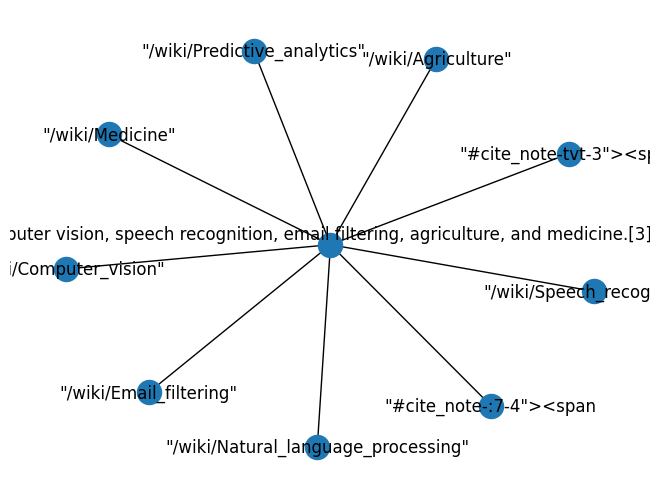

In [20]:
#Draw the graph
nx.draw(network_graphs[1], with_labels=True)

#Show the graph
plt.plot()